## CSC 177-02 Data Warehousing and Data Mining
### Mini-Project 1: Clustering
### 2016 US presedential election Twitter analysis

#### Group members: Aaron Enberg,

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import (
    preprocessing,  
    cluster as sk_cluster
)
import sklearn.feature_extraction.text as sk_text
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

In [2]:
column_names = ['Name', 'screen_Name', 'User_ID', 
                'Followers_Count', 'Friends_Count', 
                'Location', 'Description', 'Created_At', 
                'Status_ID', 'Language', 'Place', 
                'Retweet_Count', 'Favorite_Count', 'Text']

tweets = pd.read_table('data/clinton_trump_tweets.txt', names=column_names, encoding='ISO-8859-1')
tweets.columns = tweets.columns.str.lower()

In [3]:
tweets.shape

(5250980, 14)

In [4]:
tweets.dtypes

name               object
screen_name        object
user_id            int64 
followers_count    int64 
friends_count      int64 
location           object
description        object
created_at         object
status_id          int64 
language           object
place              object
retweet_count      int64 
favorite_count     int64 
text               object
dtype: object

## Preprocessing

In [5]:
tweets.drop(['name', 'screen_name', 
            'followers_count', 
            'friends_count', 
            'location', 
            'description', 
            'created_at',
            'status_id', 
            'language', 
            'place', 
            'retweet_count', 
            'favorite_count'], axis=1, inplace=True)

In [6]:
tweets.head(n=10)

,user_id,text
0,1519696717,@NWAJimmy I've read it now though brother. Was pretty spot on Lots of bright spots but a lot to work on. Exactly as an exhibition should be!
1,109945090,RT @wikileaks: New poll puts Pirate Party on course to win Iceland's national elections on Saturday. https://t.co/edTqjeJaQ6
2,1450086582,@gaystoner821 I think New Orleans spoiled me with food. I need to try and branch out in BR.
3,167177185,RT @LOLGOP: ACA needs fixes but know da facts: *70% can get covered in marketplaces for under $75/month *Hikes affect 3% *GOP will uninsu
4,1191022351,RT @FastCompany: Alphabet shares soar on better-than-expected earnings as mobile video strategy pays off https://t.co/bokbXngMJt https://t.
5,154393802,RT @Pattric: That one follower who tweet you everyday and even tho you don't respond they still be @'ing you https://t.co/QBeQyc2PO6
6,106568768,#infosec #Intel #ACM #IEEE Impacts Haswell microarch. Paper proposes mitigations that could prevent BTB-based side https://t.co/DW6vgRAPrv
7,17101060,"Hacked e-mails show Clinton campaigns fears about Sanders | https://t.co/WMyCHuCDIc The Philippine Star (PhilippineStar) October 28, 2"
8,17352518,RT @africaarguments: This year's seen some remarkable new films by African directors. Here are a few of them. https://t.co/9JEY4ubGVE http
9,2352007196,"RT @HalifaxEditor: Some 40 years later, @HfxRegPolice continue to investigate the murder of Florence Ann Keeble. https://t.co/axdvA1HUcu ht"


### Remove all retweets

In [7]:
pattern = r'^RT\s'
 
# matches retweets and removes them
tweets = tweets[tweets.text.str.match(pattern) == False]

In [8]:
tweets.shape

(2416818, 2)

In [9]:
tweets.head(n=10)

,user_id,text
0,1519696717,@NWAJimmy I've read it now though brother. Was pretty spot on Lots of bright spots but a lot to work on. Exactly as an exhibition should be!
2,1450086582,@gaystoner821 I think New Orleans spoiled me with food. I need to try and branch out in BR.
6,106568768,#infosec #Intel #ACM #IEEE Impacts Haswell microarch. Paper proposes mitigations that could prevent BTB-based side https://t.co/DW6vgRAPrv
7,17101060,"Hacked e-mails show Clinton campaigns fears about Sanders | https://t.co/WMyCHuCDIc The Philippine Star (PhilippineStar) October 28, 2"
10,16818809,Hulk smash!
12,163712593,"Well, I'm glad you got a good haircut, America's in the toilet. Is this not a conversation @Haylie_Bre and I woul https://t.co/6dVIIKZcgv"
13,2447279666,@WayneDupreeShow #climatechange is the democrats' attempt to play God
18,231921777,OH MY GOD. TEARS. https://t.co/8odjnHZwRK
20,235657662,"no lie, I been waiting for tony's story https://t.co/S5i4ESNilb"
21,201499452,How a dot-com millionaire became a social media crusader against solar amendment: It was a violation of Googl... https://t.co/ychypPZpKd


### Extract all handles and hashtags per tweet

In [10]:
# match all hashtags and mentions in a tweet, ignoring possible email addresses
pattern = r'(?<=^|(?<=[^a-zA-Z0-9-\.]))@([A-Za-z_]+[A-Za-z0-9_]+)|(?<=^|(?<=[^a-zA-Z0-9-\.]))#([A-Za-z_]+[A-Za-z0-9_]+)'

""" returns a DataFrame with a MultiIndex:
    First index is our original index. Second index is "match" which is a running
    total of the number of occurences of hashtags and mentions for a particular 
    tweet. """
handles_hashtags = tweets.text.str.extractall(pattern)

# make the dataframe look nice 
handles_hashtags.columns = ['handles', 'hashtags']
handles_hashtags = handles_hashtags.reset_index().set_index('level_0')
del handles_hashtags.index.name
handles_hashtags.drop(['match'], axis=1, inplace=True)

In [11]:
handles_hashtags.head()

,handles,hashtags
0,NWAJimmy,NaN
2,gaystoner821,NaN
6,NaN,infosec
6,NaN,Intel
6,NaN,ACM


In [12]:
# stack handles and hashtags into one column
handles_hashtags = pd.concat([handles_hashtags.handles, handles_hashtags.hashtags]).dropna().to_frame(name='handles_hashtags')

In [13]:
''' returns users along with all the hashtags/handles they've used 
    (each occurrence of a hashtag/handle will also show up in the list) '''
tweets = tweets.join(handles_hashtags, how='inner')
tweets.drop(['text'], axis=1, inplace=True)
handles_hashtags_all = tweets.reset_index().groupby('user_id')['handles_hashtags'].apply(list).to_frame()

In [14]:
handles_hashtags_all.head(n=10)

,handles_hashtags
user_id,
150,"[flangy, nelson, fjordinn, shinypb, fjordinn, fjordinn, iano, thatstacy, utilizer001, Carricohimself, fjordinn, raffi, d6, Sonikku_a, doctorow, gwestr]"
1437,"[overheardinlondon, whodeyintheUK, JimOwczarski, whodeyintheUK, AirlineFlyer, AirlineFlyer]"
1512,"[mozilla, david_bryant, SenFeinstein, marypcbuk]"
1644,"[MaryLovesBooks, BookNerdParadis, matt_hearnden, success, perspective, life, CodyBLister, Marketing, nick_eubanks, contentmarketing, promotionftw, contentmarketing, fredrivett, RobWormley, ContentMarketing, LArtra, BookNerdParadis, adamjayc, bloggingwizard, GuestBloggingStrategy, TamieDearen, BookNerdParadis, JRRTolkien, KatyHuthJones, BookNerdParadis, LorilynRoberts, BookNerdParadis, _awtozer, rahdieh, BookNerdParadis, TolkienQuote, EliseKova, BookNerdParadis, startrailsIV, BookNerdParadis, FebruaryGrace, BookNerdParadis, rtmixmktg, raecarson, BookNerdParadis, WillBluntAU, ContentMarketing, blog, LaurenLynneYA, BookNerdParadis, listbuilding, guestposting, motivation, success, emailmarketing, CRO]"
1668,[garrytan]
1737,"[nehanarkhede, ATO2016, erinscafe, MailChimp, ATO2016, rachaelmaddux, _raven_io, pwnela, GregU, PTC, Vuforia, ATO2016, nehanarkhede, erinscafe, salrelish, KyFaSt, nehanarkhede, MailChimp, ATO2016, SwiftOnSecurity, dcloues, nehanarkhede, jessfraz, erinscafe, nehanarkhede, solrac901, ApacheSpot, MailChimp, ATO2016, adickerson, ComfortablySmug, jdickerson, skamille, Michael_Tsunam1, samnesmith, bakins, JessicaMauerhan]"
2294,[qz]
2311,"[wp, ischafer, TeslaMotors, levie, SlackHQ, worldseries, hitlist_app, wandertab]"
2391,"[NathanFGao, bonaventuresoft, presserb, petshopboys, eldescanso, buzz, andymatic, petshopboys, mknepprath, dansinker, willsh, j3sse_pub, petshopboys, thelastwalt, tonx, MikeIsaac, fmanjoo, migurski, rtraister, atrubens, twitter, j3sse_pub, petshopboys, clearwriter, twitter, timbuckwalter, scarequotes, kathrynyu, summersumz, steveportigal, billder, NathanFGao, robynkanner, thelastwalt, clearwriter, hhavrilesky, TheCut, tonx, bjheinley, kowitz, yodamay, BenKennerly, michael, MaxTemkin, lmc, nczeitgeist, kathrynyu, dansays, tonx, Annaleen, TimGunn, atrubens, twitter, mnik]"


### active users with at least 20 distinct hashtags/handles

In [15]:
# returns users along with the distinct hashtags/handles they've used
handles_hashtags_distinct = tweets.reset_index().groupby('user_id')['handles_hashtags'].unique().to_frame()
# retrieve only those who have used 20 or more distinct handles/hashtags
users_active = handles_hashtags_distinct[handles_hashtags_distinct.handles_hashtags.str.len() > 19]

users_active = users_active.join(handles_hashtags_all, lsuffix='_distinct', rsuffix='_all', how='inner')

In [16]:
users_active.head()

,handles_hashtags_distinct,handles_hashtags_all
user_id,,
1644,"[MaryLovesBooks, BookNerdParadis, matt_hearnden, success, perspective, life, CodyBLister, Marketing, nick_eubanks, contentmarketing, promotionftw, fredrivett, RobWormley, ContentMarketing, LArtra, adamjayc, bloggingwizard, GuestBloggingStrategy, TamieDearen, JRRTolkien, KatyHuthJones, LorilynRoberts, _awtozer, rahdieh, TolkienQuote, EliseKova, startrailsIV, FebruaryGrace, rtmixmktg, raecarson, WillBluntAU, blog, LaurenLynneYA, listbuilding, guestposting, motivation, emailmarketing, CRO]","[MaryLovesBooks, BookNerdParadis, matt_hearnden, success, perspective, life, CodyBLister, Marketing, nick_eubanks, contentmarketing, promotionftw, contentmarketing, fredrivett, RobWormley, ContentMarketing, LArtra, BookNerdParadis, adamjayc, bloggingwizard, GuestBloggingStrategy, TamieDearen, BookNerdParadis, JRRTolkien, KatyHuthJones, BookNerdParadis, LorilynRoberts, BookNerdParadis, _awtozer, rahdieh, BookNerdParadis, TolkienQuote, EliseKova, BookNerdParadis, startrailsIV, BookNerdParadis, FebruaryGrace, BookNerdParadis, rtmixmktg, raecarson, BookNerdParadis, WillBluntAU, ContentMarketing, blog, LaurenLynneYA, BookNerdParadis, listbuilding, guestposting, motivation, success, emailmarketing, CRO]"
1737,"[nehanarkhede, ATO2016, erinscafe, MailChimp, rachaelmaddux, _raven_io, pwnela, GregU, PTC, Vuforia, salrelish, KyFaSt, SwiftOnSecurity, dcloues, jessfraz, solrac901, ApacheSpot, adickerson, ComfortablySmug, jdickerson, skamille, Michael_Tsunam1, samnesmith, bakins, JessicaMauerhan]","[nehanarkhede, ATO2016, erinscafe, MailChimp, ATO2016, rachaelmaddux, _raven_io, pwnela, GregU, PTC, Vuforia, ATO2016, nehanarkhede, erinscafe, salrelish, KyFaSt, nehanarkhede, MailChimp, ATO2016, SwiftOnSecurity, dcloues, nehanarkhede, jessfraz, erinscafe, nehanarkhede, solrac901, ApacheSpot, MailChimp, ATO2016, adickerson, ComfortablySmug, jdickerson, skamille, Michael_Tsunam1, samnesmith, bakins, JessicaMauerhan]"
2391,"[NathanFGao, bonaventuresoft, presserb, petshopboys, eldescanso, buzz, andymatic, mknepprath, dansinker, willsh, j3sse_pub, thelastwalt, tonx, MikeIsaac, fmanjoo, migurski, rtraister, atrubens, twitter, clearwriter, timbuckwalter, scarequotes, kathrynyu, summersumz, steveportigal, billder, robynkanner, hhavrilesky, TheCut, bjheinley, kowitz, yodamay, BenKennerly, michael, MaxTemkin, lmc, nczeitgeist, dansays, Annaleen, TimGunn, mnik]","[NathanFGao, bonaventuresoft, presserb, petshopboys, eldescanso, buzz, andymatic, petshopboys, mknepprath, dansinker, willsh, j3sse_pub, petshopboys, thelastwalt, tonx, MikeIsaac, fmanjoo, migurski, rtraister, atrubens, twitter, j3sse_pub, petshopboys, clearwriter, twitter, timbuckwalter, scarequotes, kathrynyu, summersumz, steveportigal, billder, NathanFGao, robynkanner, thelastwalt, clearwriter, hhavrilesky, TheCut, tonx, bjheinley, kowitz, yodamay, BenKennerly, michael, MaxTemkin, lmc, nczeitgeist, kathrynyu, dansays, tonx, Annaleen, TimGunn, atrubens, twitter, mnik]"
2426,"[MikeIsaac, thelancearthur, FFWglobal, SenFeinstein, shootatweet, NancyPelosi, abookapart, SenatorBoxer, GOP, united, designhawg, JoeGermuska, knightlab, Real_TJ_Thomas, gruber, parisvega, espiekermann, MikeHosier, ChappellTracker, drwave, beaucolburn, choad, halvorson, facebook, sjarvis, zeldman, natts, astronautpnguin, matt_timmons, austinkleon, de5igner, madebyfew, gunsonfacebookrightnow, romanmars, mat, sonia__harris, SherylCababa, dansinker, facebooks, jbsibley, blocktogether, ToddRoss, MxF2016]","[MikeIsaac, thelancearthur, FFWglobal, SenFeinstein, shootatweet, SenFeinstein, shootatweet, NancyPelosi, shootatweet, abookapart, SenatorBoxer, shootatweet, GOP, united, designhawg, JoeGermuska, knightlab, MikeIsaac, NancyPelosi, shootatweet, NancyPelosi, shootatweet, Real_TJ_Thomas, gruber, SenatorBoxer, shootatweet, parisvega, espiekermann, MikeHosier, ChappellTracker, drwave, beaucolburn, choad, halvorson, NancyPelosi, shootatweet, designhawg, SenFeinstein, shootatweet, Sena

In [17]:
users_active['handles_hashtags_stringified'] = users_active['handles_hashtags_all'].apply(lambda x: ' '.join(map(str, x)))

In [18]:
''' each string in the list contains all the hashtags/handles for one user 
    (contains duplicates if they used a hashtag/handle more than once) '''
corpus = list(users_active['handles_hashtags_stringified'])

### hashtags/handles that have been used by at least 20 distinct users (min_df=20)

In [36]:
# constructs a dataframe with only the handles/hashtags used by 20 users 
vectorizer = sk_text.CountVectorizer(min_df=20, lowercase=True, encoding='ISO-8859-1')
matrix = vectorizer.fit_transform(corpus)
df_idx_id = pd.DataFrame(matrix.toarray(), index=users_active.index, columns=vectorizer.get_feature_names())

In [37]:
# columns are hashtags and handles and values are frequency of handle/hashtag for a given user
df_idx_id.head()

,_altright_anew,_carja,_cfj_,_makada_,_proud_american,_realvalentina_,a_miller48,abbydphillip,abbymartin,abbymartinm,...,zachhaller,zaibatsunews,zaidjilani,zekejmiller,zerohedge,zhaabowekwe,zigmanfreud,zika,zimmermanrob,zip90210
user_id,,,,,,,,,,,,,,,,,,,,,
1644,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2426,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14763,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
df_idx_id.shape

(17066, 4035)

In [52]:
# same matrix just swapped rows and columns
df_idx_hashtags = df_idx_id.transpose().reset_index(drop=True)

In [53]:
df_idx_hashtags.head()

user_id,1644,1737,2391,2426,14763,1026541,1134681,1201691,1253141,1329901,...,2519981617,2520294360,2520480397,2520487656,2520839886,2521149576,2521541502,2521805227,2521929295,2522444346
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
df_idx_hashtags = df_idx_hashtags.transpose()

In [55]:
df_idx_hashtags.head()

,0,1,2,3,4,5,6,7,8,9,...,4025,4026,4027,4028,4029,4030,4031,4032,4033,4034
user_id,,,,,,,,,,,,,,,,,,,,,
1644,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2426,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14763,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
labels = pd.read_table('./data/clinton_trump_user_classes.txt',
                       names=['user_id', 'label'])
labels.set_index('user_id', inplace=True)

In [25]:
df_idx_id.join(labels, how='inner').head()

,_altright_anew,_carja,_cfj_,_makada_,_proud_american,_realvalentina_,a_miller48,abbydphillip,abbymartin,abbymartinm,...,zaibatsunews,zaidjilani,zekejmiller,zerohedge,zhaabowekwe,zigmanfreud,zika,zimmermanrob,zip90210,label
user_id,,,,,,,,,,,,,,,,,,,,,
1644,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2426,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
14763,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [56]:
std_scaler = preprocessing.StandardScaler()

X_std = std_scaler.fit_transform(df_idx_id)

In [57]:
X_normalized = preprocessing.normalize(df_idx_hashtags)

Text(0,0.5,'SSE')

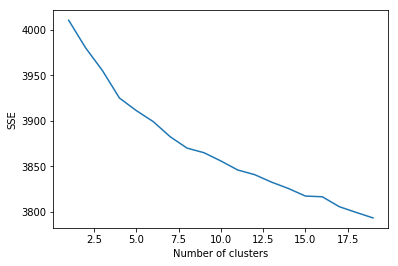

In [35]:
error = np.zeros(20)
for k in range(1,20):
    kmeans = sk_cluster.KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit_predict(X_normalized)
    error[k] = kmeans.inertia_

plt.plot(range(1, 20),error[1:])
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

In [58]:
kmeans = sk_cluster.KMeans(init='k-means++', n_clusters=6, n_init=10, max_iter=300)  

# n_init: Number of time the k-means algorithm will be run 
# max_iter : int, default: 300

kmeans.fit_predict(X_normalized)

print ('\n Cluster Centroids')
centroids = kmeans.cluster_centers_
print (centroids)

print ('\nCluster labels')
kmeans_labels = kmeans.labels_
print(kmeans_labels)


print('\n')
error = kmeans.inertia_       #SSE; Sum of squared distances of samples to their closest cluster center.
print ("The total error of the clustering is: ", error)


 Cluster Centroids
[[ 4.16139057e-05  2.17855430e-04  2.05292084e-04 ...  1.19379381e-04
   5.99296853e-04  2.36490989e-04]
 [ 5.96935689e-04  3.14838416e-04  1.69379943e-04 ...  4.02240057e-05
   4.71798670e-04  4.02220842e-04]
 [ 2.35938572e-04  1.89247063e-04  3.49741363e-05 ...  2.96460142e-04
   5.95626974e-05  1.10368571e-04]
 [ 9.40950056e-05 -1.02999206e-18 -7.72494048e-19 ...  1.48012711e-04
   7.58941521e-19  5.67753689e-05]
 [-2.49366500e-18 -1.05709712e-18 -8.67361738e-19 ...  1.43384834e-04
   1.05709712e-18  1.95156391e-18]
 [-1.62630326e-18 -1.00288701e-18 -6.36968776e-19 ...  4.40973864e-04
   0.00000000e+00  3.52365706e-19]]

Cluster labels
[2 2 2 ... 2 2 2]


The total error of the clustering is:  14741.187137964589


In [59]:
print(kmeans.cluster_centers_)
asc_order_centroids = kmeans.cluster_centers_.argsort()    # argsort() returns the indices that would sort an array.
print(asc_order_centroids)

des_order_centroids = asc_order_centroids[:,::-1]     #  get the indices in descending order
print(des_order_centroids)

[[ 4.16139057e-05  2.17855430e-04  2.05292084e-04 ...  1.19379381e-04
   5.99296853e-04  2.36490989e-04]
 [ 5.96935689e-04  3.14838416e-04  1.69379943e-04 ...  4.02240057e-05
   4.71798670e-04  4.02220842e-04]
 [ 2.35938572e-04  1.89247063e-04  3.49741363e-05 ...  2.96460142e-04
   5.95626974e-05  1.10368571e-04]
 [ 9.40950056e-05 -1.02999206e-18 -7.72494048e-19 ...  1.48012711e-04
   7.58941521e-19  5.67753689e-05]
 [-2.49366500e-18 -1.05709712e-18 -8.67361738e-19 ...  1.43384834e-04
   1.05709712e-18  1.95156391e-18]
 [-1.62630326e-18 -1.00288701e-18 -6.36968776e-19 ...  4.40973864e-04
   0.00000000e+00  3.52365706e-19]]
[[1025 2015 2351 ... 1227 2948 1512]
 [ 912 2456 2804 ... 2306 1512 2948]
 [1033 1759 2149 ...  665 3687 2948]
 [3358 2509 1693 ... 1512 2948 4021]
 [3714 2206 3358 ... 1664  780 3976]
 [3547  544 2194 ... 4021 1512 1449]]
[[1512 2948 1227 ... 2351 2015 1025]
 [2948 1512 2306 ... 2804 2456  912]
 [2948 3687  665 ... 2149 1759 1033]
 [4021 2948 1512 ... 1693 2509 3358

In [60]:
terms = vectorizer.get_feature_names()
print(terms, '\n')
for i in range(6):
    print ("Cluster:", i)
    for ind in des_order_centroids[i, :10]:
        print (terms[ind])
    print() 

['_altright_anew', '_carja', '_cfj_', '_makada_', '_proud_american', '_realvalentina_', 'a_miller48', 'abbydphillip', 'abbymartin', 'abbymartinm', 'abc', 'abc13houston', 'abc7', 'abc7ny', 'abcdesignated', 'abcliz', 'abcnetwork', 'abcnews', 'abcpolitics', 'abcsharktank', 'abcworldnews', 'abedin', 'abortion', 'ac360', 'aca', 'aclu', 'acosta', 'acoyne', 'activist360', 'actualflatticus', 'ad', 'adambaldwin', 'adamgoldmannyt', 'adamjohnsonnyc', 'adamparkhomenko', 'adamschefter', 'adamserwer', 'adamsflafan', 'adamweinstein', 'addaclownruinamovie', 'adele', 'adgpi', 'adhm', 'adirado29', 'adoptdontshop', 'aduanebrown', 'advertising', 'advice', 'adweek', 'aedwardslevy', 'afghanistan', 'aflcio', 'afneil', 'afp', 'africa', 'ag_conservative', 'agentsergeevna', 'agentsofshield', 'agpambondi', 'agriculture', 'ahs', 'ahs6', 'ahsfx', 'ahsroanoke', 'ai', 'aidenwolfe', 'aids', 'aiiamericangiri', 'airbnb', 'ajaydevgn', 'ajdelgado13', 'ajenews', 'ajenglish', 'ajplus', 'alabama', 'alancolmes', 'alankestrel

In [61]:
ag = sk_cluster.AgglomerativeClustering(linkage='ward', n_clusters=6)   

#complete: The maximum distances
#n_clusters: The number of clusters to find.

ag_labels = ag.fit_predict(X_normalized)
ag_labels

array([0, 0, 0, ..., 0, 0, 0])